# let's install pycaret !


In [1]:
# Install PyCaret
#!pip install pycaret
#!pip install --upgrade pycaret #if you have installed beta version in past, run the below code to upgrade
import os, sys
path = '/Users/maurizio/opt/anaconda3'
sys.path.append(f'{path}/lib/python3.10/site-packages')
sys.path.append(f'{path}/lib')

import numpy as np
import pandas as pd
import os, sys
from IPython.display import display

from pycaret.utils import version

# PyCaret version
version()

'3.2.0'

In [2]:
from pycaret.classification import *

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from typing import List
def load_features(filenames: List[str] = [], fixnans= [], normalizes=[], colname: str="label", 
                  verbose: bool = False, show_progress: bool = False) -> pd.DataFrame:
    """
    Load and assemble features and labels for machine learning tasks.

    :param List[str] features: List of feature filepaths
    :param str colname: Name of the column in the label file to be used as the target variable. Default is "label".
    :param int seed: Random seed for reproducibility. Default is 1.
    :param bool verbose: Whether to print verbose messages during processing. Default is False.
    :param bool show_progress: Whether to print progress bar while loading file. Default is False.

    :returns: Tuple containing the assembled features (X) and labels (Y) DataFrames.
    :rtype: Tuple[pd.DataFrame, pd.DataFrame]
        
    :example:

    .. code-block:: python

        colname = "target_column"
        seed = 1
        verbose = False

        df_label = pd.read_csv("label_file.csv2, index_col=0)
        X, Y = load_features(['path/to/feature_file1.csv', 'path/to/feature_file2.csv'], fix_na=True, colname, seed, verbose)
    """

    # Common indices among labels and features
    x = pd.DataFrame()

    # Process each feature file
    for f,fixna,norm in zip(filenames, fixnans, normalizes):
        feat_df = pd.read_csv(f, index_col=0)
        feat_df.index = feat_df.index.map(str)
        fname = os.path.basename(f).rsplit('.', 1)[0]

        # Handle missing values if required
        if verbose:
            cntnan = feat_df.isna().sum().sum()
            print(f"[{fname}] found {cntnan} Nan...")
        if fixna:
            if verbose:
                print(f"[{fname}] Fixing NaNs with mean ...")
            feat_df = feat_df.fillna(feat_df.mean())

        # Normalize features
        if norm == 'std':
            scaler = MinMaxScaler()
            if verbose:
                print(f"[{fname}] Normalization with {norm} ...")
            feat_df = pd.DataFrame(scaler.fit_transform(feat_df), index=feat_df.index, columns=feat_df.columns)
        elif norm == 'max':
            scaler = StandardScaler()
            if verbose:
                print(f"[{fname}] Normalization with {norm}...")
            feat_df = pd.DataFrame(scaler.fit_transform(feat_df), index=feat_df.index, columns=feat_df.columns)
        else:
            if verbose:
                print(f"[{fname}] No normalization...")

        # merge features features
        x = pd.merge(x, feat_df, left_index=True, right_index=True, how='outer')

    # Return the assembled features (X) and labels (Y)
    return x

# Load the dataset and split

In [4]:
from sklearn.model_selection import train_test_split
path = '../../data/'
attributes = load_features([os.path.join(path, 'Kidney_BIO.csv'), 
                            #os.path.join(path, 'Kidney_CCcfs.csv'),
                            os.path.join(path, 'Kidney_EmbN2V_128.csv')], 
                            fixnans=[True, True, False], normalizes=['std', 'std', None], verbose=True)
label = pd.read_csv(os.path.join(path,'Kidney_HELP.csv'), index_col=0).replace({'aE':'NE', 'sNE': 'NE'})
idx_common = np.intersect1d(attributes.index.values, label.index.values)
attributes = attributes.loc[idx_common]
label = label.loc[idx_common]
X_train, X_test, y_train, y_test = train_test_split(attributes, label, shuffle=False)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

[Kidney_BIO] found 52532 Nan...
[Kidney_BIO] Fixing NaNs with mean ...
[Kidney_BIO] Normalization with std ...
[Kidney_EmbN2V_128] found 0 Nan...
[Kidney_EmbN2V_128] Fixing NaNs with mean ...
[Kidney_EmbN2V_128] Normalization with std ...


# Start tuning session

In [5]:
clf1 = setup(data = train, 
             target = 'label',
             numeric_imputation = 'mean',
             categorical_features = [], session_id = 444,
             fold_strategy = "stratifiedkfold", fold=5,
             #ignore_features = ['Name','Ticket','Cabin'],
             verbose = True)

,Description,Value
0,Session id,444
1,Target,label
2,Target type,Binary
3,Target mapping,"E: 0, NE: 1"
4,Original data shape,"(12927, 155)"
5,Transformed data shape,"(12927, 155)"
6,Transformed train set shape,"(9048, 155)"
7,Transformed test set shape,"(3879, 155)"
8,Numeric features,154
9,Preprocess,True


# Adjuts metrics

In [6]:
from sklearn.metrics import *
from imblearn.metrics import specificity_score
try: 
    [remove_metric(m) for m in ['Precision', 'F1', 'Kappa']]  # remove unused metrics
    add_metric('Sensitivity', 'Sensitivity', specificity_score, greater_is_better = True)
    add_metric('Specificity', 'Specificity', recall_score, greater_is_better = True)
    add_metric('Balanced Accuracy', 'BA', balanced_accuracy_score, greater_is_better = True)
    #add_metric('ROC-AUC', 'ROC-AUC', roc_auc_score, greater_is_better = True, multiclass=False)
except: 
    pass
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7fbff13da700>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x7fbff13da9d0>,make_scorer(matthews_corrcoef),pred,{},True,True,False
Sensitivity,Sensitivity,Sensitivity,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(specificity_score),pred,{},True,True,True
Specificity,Specificity,Specificity,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(recall_score),pred,{},True,True,True
Balanced Accuracy,BA,BA,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(balanced_accuracy_score),pred,{},True,True,True


# Define our model

In [7]:
from HELPpy.models.prediction import VotingEnsembleLGBM
veLGBM = create_model(VotingEnsembleLGBM())

,Accuracy,AUC,Recall,MCC,Sensitivity,Specificity,BA
Fold,,,,,,,
0,0.8834,0.9451,0.8834,0.5308,0.8872,0.8831,0.8852
1,0.8945,0.9541,0.8945,0.5466,0.8722,0.8962,0.8842
2,0.8939,0.9523,0.8939,0.5556,0.8947,0.8939,0.8943
3,0.8706,0.9383,0.8706,0.5019,0.8788,0.8700,0.8744
4,0.8806,0.9466,0.8806,0.5027,0.8409,0.8837,0.8623
Mean,0.8846,0.9473,0.8846,0.5275,0.8748,0.8854,0.8801
Std,0.0089,0.0056,0.0089,0.0221,0.0186,0.0093,0.0109


In [8]:
from sklearn.metrics import balanced_accuracy_score
classifiers = [VotingEnsembleLGBM(), 'lightgbm', 'xgboost', 'ada', 'rf', 'dt', 'gbc', 'lda', 'lr', 'et', 'svm']
results = compare_models(include=classifiers, sort='BA')

,Model,Accuracy,AUC,Recall,MCC,Sensitivity,Specificity,BA,TT (Sec)
0,VotingEnsembleLGBM,0.8846,0.9473,0.8846,0.5275,0.8748,0.8854,0.8801,4.0240
7,Linear Discriminant Analysis,0.9422,0.9340,0.9422,0.5669,0.5867,0.9703,0.7785,0.3640
10,SVM - Linear Kernel,0.9439,0.0000,0.9439,0.5519,0.5126,0.9779,0.7453,0.1880
3,Ada Boost Classifier,0.9402,0.9238,0.9402,0.5097,0.4691,0.9775,0.7233,2.3640
8,Logistic Regression,0.9478,0.9428,0.9478,0.5494,0.4480,0.9874,0.7177,0.3960
1,Light Gradient Boosting Machine,0.9476,0.9460,0.9476,0.5365,0.4057,0.9905,0.6981,0.8580
2,Extreme Gradient Boosting,0.9470,0.9412,0.9470,0.5296,0.4012,0.9901,0.6957,8.5740
6,Gradient Boosting Classifier,0.9444,0.9322,0.9444,0.4942,0.3530,0.9912,0.6721,14.3980
5,Decision Tree Classifier,0.8991,0.6538,0.8991,0.2941,0.3665,0.9412,0.6538,1.2180
4,Random Forest Classifier,0.9358,0.9161,0.9358,0.3383,0.1312,0.9994,0.5653,2.3880


In [10]:
df = pull()
df.to_csv(os.path.join('../../data4rev/pycaret/', "pycaret_best_classifier_metrics.csv"), index=True)
print(df.to_latex())

\begin{tabular}{llrrrrrrrr}
\toprule
{} &                            Model &  Accuracy &     AUC &  Recall &     MCC &  Sensitivity &  Specificity &      BA &  TT (Sec) \\
\midrule
0  &               VotingEnsembleLGBM &    0.8846 &  0.9473 &  0.8846 &  0.5275 &       0.8748 &       0.8854 &  0.8801 &     4.024 \\
7  &     Linear Discriminant Analysis &    0.9422 &  0.9340 &  0.9422 &  0.5669 &       0.5867 &       0.9703 &  0.7785 &     0.364 \\
10 &              SVM - Linear Kernel &    0.9439 &  0.0000 &  0.9439 &  0.5519 &       0.5126 &       0.9779 &  0.7453 &     0.188 \\
3  &             Ada Boost Classifier &    0.9402 &  0.9238 &  0.9402 &  0.5097 &       0.4691 &       0.9775 &  0.7233 &     2.364 \\
8  &              Logistic Regression &    0.9478 &  0.9428 &  0.9478 &  0.5494 &       0.4480 &       0.9874 &  0.7177 &     0.396 \\
1  &  Light Gradient Boosting Machine &    0.9476 &  0.9460 &  0.9476 &  0.5365 &       0.4057 &       0.9905 &  0.6981 &     0.858 \\
2  &     

In [114]:
results.get_params()

{'n_jobs': -1,
 'n_voters': 10,
 'random_state': 42,
 'verbose': False,
 'voting': 'soft'}

# Tune the veLGBM classifier

In [46]:
velgbm = create_model(VotingEnsembleLGBM())
hparams = {"n_voters" :[4, 6, 8, 10, 12], 
           'boosting_type': ['gbdt', 'dart'], 
           'learning_rate' :[0.1, 0.2, 0.4]}
tuned_veLGBM, tuner = tune_model(velgbm, optimize = 'BA', search_algorithm='grid', custom_grid=hparams, return_tuner=True)

,Accuracy,AUC,Recall,MCC,Sensitivity,Specificity,BA
Fold,,,,,,,
0,0.8834,0.9451,0.8834,0.5308,0.8872,0.8831,0.8852
1,0.8945,0.9541,0.8945,0.5466,0.8722,0.8962,0.8842
2,0.8939,0.9523,0.8939,0.5556,0.8947,0.8939,0.8943
3,0.8706,0.9383,0.8706,0.5019,0.8788,0.8700,0.8744
4,0.8806,0.9466,0.8806,0.5027,0.8409,0.8837,0.8623
Mean,0.8846,0.9473,0.8846,0.5275,0.8748,0.8854,0.8801
Std,0.0089,0.0056,0.0089,0.0221,0.0186,0.0093,0.0109


,Accuracy,AUC,Recall,MCC,Sensitivity,Specificity,BA
Fold,,,,,,,
0,0.8685,0.9477,0.8685,0.5172,0.9173,0.8646,0.8910
1,0.8746,0.9540,0.8746,0.5176,0.8947,0.8730,0.8839
2,0.8779,0.9551,0.8779,0.5340,0.9173,0.8748,0.8960
3,0.8574,0.9394,0.8574,0.4795,0.8788,0.8557,0.8672
4,0.8723,0.9477,0.8723,0.5014,0.8712,0.8724,0.8718
Mean,0.8701,0.9488,0.8701,0.5099,0.8959,0.8681,0.8820
Std,0.0071,0.0056,0.0071,0.0184,0.0191,0.0071,0.0110


Fitting 5 folds for each of 30 candidates, totalling 150 fits


# learning curve

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator VotingEnsembleLGBM(boosting_type='gbdt', learning_rate=0.1, n_jobs=-1,
                   n_voters=10, random_state=42, verbose=False, voting='soft') does not.

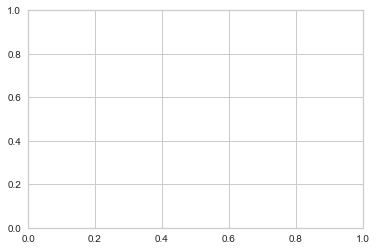

In [28]:
plot_model(estimator = tuned_veLGBM, plot = 'learning')

# AUC curve

In [24]:
plot_model(estimator = tuned_veLGBM, plot = 'auc')

YellowbrickTypeError: This estimator is not a classifier; try a regression or clustering score visualizer instead!

# Confusion Matrix

In [29]:
plot_model(estimator = tuned_veLGBM, plot = 'confusion_matrix')

YellowbrickTypeError: This estimator is not a classifier; try a regression or clustering score visualizer instead!

# Future importance

In [40]:
plot_model(estimator = tuned_veLGBM, plot = 'feature')

TypeError: Feature Importance and RFE plots not available for estimators that doesnt support coef_ or feature_importances_ attribute.

In [31]:
interpret_model(tuned_veLGBM)

ModuleNotFoundError: 
'shap' is a soft dependency and not included in the pycaret installation. Please run: `pip install shap` to install.
Alternately, you can install this by running `pip install pycaret[analysis]`

## all params

In [41]:
evaluate_model(tuned_veLGBM)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Save reports

In [42]:
df2 = pull()
df2.to_csv(os.path.join('../../data4rev/pycaret/', "tuned_veLGB.csv"))
pd.DataFrame(tuner.cv_results_).to_csv("veLGB_opt_lr_nv_bt.csv", index=True)

In [47]:
pd.DataFrame(tuner.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_actual_estimator__boosting_type,param_actual_estimator__learning_rate,param_actual_estimator__n_voters,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,20.880798,2.481754,1.224123,0.157170,gbdt,0.1,4,"{'actual_estimator__boosting_type': 'gbdt', 'a...",0.806495,0.833407,0.811149,0.830210,0.834682,0.823189,0.011912,28
1,22.290294,5.125205,1.508487,0.331046,gbdt,0.1,6,"{'actual_estimator__boosting_type': 'gbdt', 'a...",0.850960,0.854720,0.850182,0.866245,0.851568,0.854735,0.005958,20
2,27.013006,0.082861,2.112856,0.374372,gbdt,0.1,8,"{'actual_estimator__boosting_type': 'gbdt', 'a...",0.874243,0.876446,0.883965,0.869172,0.856494,0.872064,0.009125,13
3,40.738191,3.339288,1.752699,0.174316,gbdt,0.1,10,"{'actual_estimator__boosting_type': 'gbdt', 'a...",0.885171,0.884212,0.894297,0.874397,0.862315,0.880079,0.010891,4
4,33.407686,3.734489,2.777990,0.830967,gbdt,0.1,12,"{'actual_estimator__boosting_type': 'gbdt', 'a...",0.870264,0.887025,0.882851,0.867749,0.860052,0.873588,0.009947,9
5,19.536955,0.431578,0.666609,0.129696,gbdt,0.2,4,"{'actual_estimator__boosting_type': 'gbdt', 'a...",0.814014,0.848445,0.818370,0.829315,0.834980,0.829025,0.012260,26
6,23.117947,2.561167,1.602942,0.171563,gbdt,0.2,6,"{'actual_estimator__boosting_type': 'gbdt', 'a...",0.860566,0.858479,0.857701,0.863948,0.857951,0.859729,0.002338,19
7,24.571799,0.899603,2.527226,0.518756,gbdt,0.2,8,"{'actual_estimator__boosting_type': 'gbdt', 'a...",0.869407,0.876446,0.881398,0.876450,0.867858,0.874312,0.005001,8
8,37.361810,1.047441,1.799591,0.293427,gbdt,0.2,10,"{'actual_estimator__boosting_type': 'gbdt', 'a...",0.877951,0.884510,0.902711,0.873292,0.867892,0.881271,0.012032,2
9,30.621578,2.224174,2.793503,0.816252,gbdt,0.2,12,"{'actual_estimator__boosting_type': 'gbdt', 'a...",0.881659,0.885534,0.896813,0.864856,0.869118,0.879596,0.011515,5


In [48]:
print(pd.DataFrame(tuner.cv_results_)[['param_actual_estimator__n_voters', 
                                 'param_actual_estimator__boosting_type',
                                 'param_actual_estimator__learning_rate',
                                 'rank_test_score', 
                                 'mean_test_score']].sort_values('mean_test_score', 
                                                                       ascending=False).to_latex())

\begin{tabular}{llllrr}
\toprule
{} & param\_actual\_estimator\_\_n\_voters & param\_actual\_estimator\_\_boosting\_type & param\_actual\_estimator\_\_learning\_rate &  rank\_test\_score &  mean\_test\_score \\
\midrule
14 &                               12 &                                  gbdt &                                   0.4 &                1 &         0.881981 \\
8  &                               10 &                                  gbdt &                                   0.2 &                2 &         0.881271 \\
13 &                               10 &                                  gbdt &                                   0.4 &                3 &         0.880275 \\
3  &                               10 &                                  gbdt &                                   0.1 &                4 &         0.880079 \\
9  &                               12 &                                  gbdt &                                   0.2 &                5 &      